# Exploration

## Imports

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.decomposition import PCA

In [3]:
import mvi.utils as mvi_utils

## Config

In [4]:
DATA_DIR_PATH = "../data/"

PATH_RAW = os.path.join(DATA_DIR_PATH, "train_join.csv")
PATH_PREPROCESSED = os.path.join(DATA_DIR_PATH, "train_preprocessed.csv")

mvi_utils.list_data_files(DATA_DIR_PATH)

Available files:
  test_preprocessed.csv
  macro.csv
  test.csv
  train.csv
  train_synth_ctgan.csv
  train_preprocessed.csv
  train_join.csv


## Read data

In [5]:
def _read_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=["timestamp"])

In [6]:
df_train_raw = _read_data(PATH_RAW)
df_train_preprocessed = _read_data(PATH_PREPROCESSED)

df_features = df_train_raw.drop(["id", "timestamp"], axis=1) 

In [7]:
df_train_raw.head()

id  price_doc  timestamp  full_sq  life_sq  floor  max_floor  material  \
0   29    8254400 2011-09-26       73     38.0   15.0        NaN       NaN   
1  148   14103600 2011-10-18      117    108.0   20.0        NaN       NaN   
2  281   11380040 2011-11-03       83     83.0   18.0        NaN       NaN   
3  560   10100958 2011-12-07       73      NaN   14.0        NaN       NaN   
4  562    9672200 2011-12-07       70     36.0    9.0        NaN       NaN   

   build_year  num_room  kitch_sq  state    cpi  employment   salary  \
0         NaN       NaN       NaN    NaN  353.2       0.708  44898.7   
1         NaN       NaN       NaN    NaN  353.0       0.708  44898.7   
2         NaN       NaN       NaN    NaN  354.7       0.708  44898.7   
3         NaN       NaN       NaN    NaN  356.2       0.708  44898.7   
4         NaN       NaN       NaN    NaN  356.2       0.708  44898.7   

   salary_growth  deposits_value  mortgage_rate  
0       0.168917        10920215          11.92  
1       0.168917        10920215          11.57  
2       0.168917        10876079          11.74  
3       0.168917        11061372          11.40  
4       0.168917        11061372          11.40

## Basic info

In [8]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11023 entries, 0 to 11022
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_doc       11023 non-null  int64  
 1   full_sq         11023 non-null  int64  
 2   life_sq         4641 non-null   float64
 3   floor           10933 non-null  float64
 4   max_floor       7297 non-null   float64
 5   material        7297 non-null   float64
 6   build_year      3348 non-null   float64
 7   num_room        7297 non-null   float64
 8   kitch_sq        7297 non-null   float64
 9   state           4523 non-null   float64
 10  cpi             11023 non-null  float64
 11  employment      11023 non-null  float64
 12  salary          11023 non-null  float64
 13  salary_growth   11023 non-null  float64
 14  deposits_value  11023 non-null  int64  
 15  mortgage_rate   11023 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 1.3 MB


In [9]:
df_features.nunique()

price_doc         7689
full_sq            157
life_sq            143
floor               32
max_floor           36
material             6
build_year          15
num_room             7
kitch_sq            49
state                4
cpi                 46
employment           5
salary               5
salary_growth        5
deposits_value      42
mortgage_rate       39
dtype: int64

In [11]:
df_features.nunique().loc[df_features.nunique() < 10]

material         6
num_room         7
state            4
employment       5
salary           5
salary_growth    5
dtype: int64

---

## Definitions

In [12]:
COLUMNS_CAT = [
    "material",
    "state",
]

COLUMNS_CONT = [col for col in df_features if col not in COLUMNS_CAT]
COLUMNS_CONT

['price_doc',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'build_year',
 'num_room',
 'kitch_sq',
 'cpi',
 'employment',
 'salary',
 'salary_growth',
 'deposits_value',
 'mortgage_rate']

In [13]:
def _fill_missing_median(df: pd.DataFrame) -> pd.DataFrame:
    """Fills missing values with its median"""
    cols_fill = [col for col in COLUMNS_CONT if col in df.columns]
    means = df.loc[:, cols_fill].mean(numeric_only=True)
    df.loc[:, cols_fill] = df.loc[:, cols_fill].fillna(means) 
    return df
    
    
def _factorize_categorcical(df: pd.DataFrame) -> pd.DataFrame:
    cols_fac = [col for col in COLUMNS_CAT if col in df.columns]
    for col in cols_fac:
        df.loc[:, col], _ = pd.factorize(df.loc[:, col], sort=True)
        
    return df

## Outliers

In [14]:
df_filled = (df_features
             .transform(_fill_missing_median)
             .transform(_factorize_categorcical)
            )

In [15]:
df_filled.isnull().sum()

price_doc         0
full_sq           0
life_sq           0
floor             0
max_floor         0
material          0
build_year        0
num_room          0
kitch_sq          0
state             0
cpi               0
employment        0
salary            0
salary_growth     0
deposits_value    0
mortgage_rate     0
dtype: int64

### Remove

Based on Z-score: 

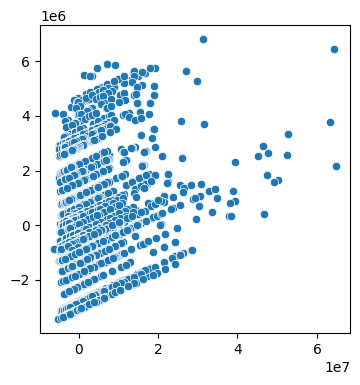

In [19]:
components = mvi_utils.get_pca(df_filled)

In [20]:
df_clean = mvi_utils.remove_outliers_zscore(df_filled)

[zscore] Number of removed samples: 1472


### PCA after

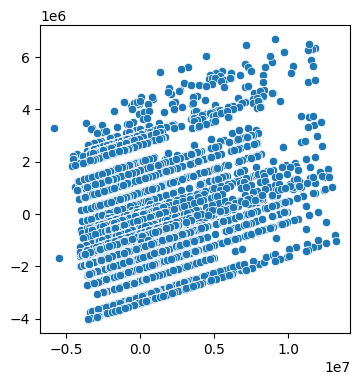

In [21]:
components = mvi_utils.get_pca(df_clean)

In [22]:
df_components = pd.DataFrame(data=components, columns=["component_1", "component_2"])
df_components

component_1   component_2
0     1.345465e+06  5.447375e+06
1     7.104334e+06  6.471373e+06
2     4.415108e+06  6.038024e+06
3     3.188218e+06  5.631669e+06
4     2.766081e+06  5.556608e+06
...            ...           ...
9546  3.897711e+05 -3.318283e+06
9547  5.081358e+06 -2.484061e+06
9548  4.803654e+06 -2.533440e+06
9549  1.346426e+06 -3.148178e+06
9550  1.563428e+06 -3.109592e+06

[9551 rows x 2 columns]

---

In [24]:
df_features.infer_objects().dtypes

price_doc           int64
full_sq             int64
life_sq           float64
floor             float64
max_floor         float64
material            int64
build_year        float64
num_room          float64
kitch_sq          float64
state               int64
cpi               float64
employment        float64
salary            float64
salary_growth     float64
deposits_value      int64
mortgage_rate     float64
dtype: object

In [ ]:
import torch.utils
import torchvision

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [ ]:
for x, y in data:
    print(x.shape)
    print(y.shape)
    break

---